# Air Brakes Example


Lets make a simple air brakes example. We will use the same model as in the [getting started](getting_started.ipynb) example, but we will add a simple air brakes model.


In [1]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib widget

## Setting Up a Simulation


Lets define everything we need up to the rocket


Gravity Details

Acceleration of Gravity at Lauch Site: 9.79133308624842 m/s²


Launch Site Details

Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1400.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 856.02 hPa
Surface Temperature: 279.07 K
Surface Air Density: 1.069 kg/m³
Surface Speed of Sound: 334.55 m/s


Atmospheric Model Plots



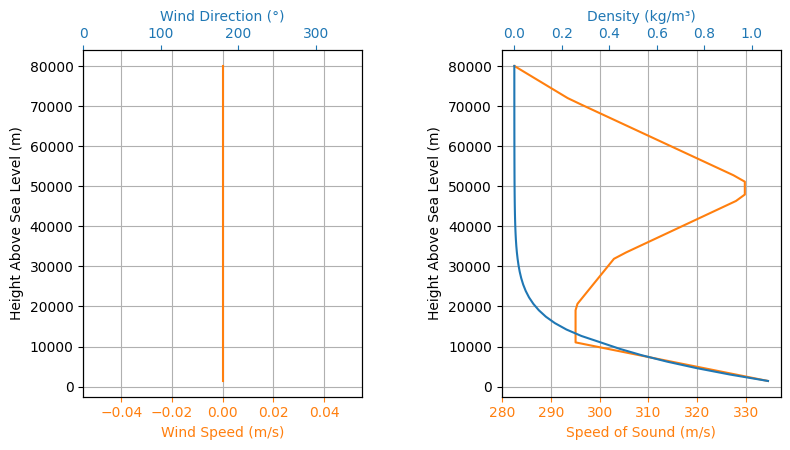

In [2]:
env = Environment(latitude=32.990254, longitude=-106.974998, elevation=1400)

env.info()

In [3]:
Pro75M1670 = SolidMotor(
    thrust_source="../../data/motors/Cesaroni_M1670.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

In [4]:
calisto = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="../../data/calisto/powerOffDragCurve.csv",
    power_on_drag="../../data/calisto/powerOnDragCurve.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = calisto.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

calisto.add_motor(Pro75M1670, position=-1.255)

nose_cone = calisto.add_nose(
    length=0.55829, kind="vonKarman", position=1.278
)

fin_set = calisto.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    airfoil=("../../data/calisto/NACA0012-radians.csv","radians"),
)

tail = calisto.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)


## Setting Up the Air Brakes

Now we can get started!

To create an air brakes model, we need to define the following:

* The air brakes' drag coefficient as a function of the air brakes' deployed level and of the Mach number. This can be done by defining by inputing the directory of a CSV file containing the drag coefficient as a function of the air brakes' deployed level and of the Mach number. The CSV file must contain no headers and must have three columns: the first column must be the air brakes' deployed level, the second column must be the Mach number, and the third column must be the drag coefficient.

* The controller function, which takes in the current time, the current state, and the `AirBrakes` instance being defined, and sets the desired air brakes' deployed level. The air brakes' deployed level must be between 0 and 1, and must be set using the `set_deployed_level` method of the `AirBrakes` instance being defined. Inside this function, any controller logic, filters, and apogee prediction can be implemented.

* The sampling rate of the controller function, in seconds. This is the time between each call of the controller function, in simulation time. Must be given in Hertz.

Lets start by defining a very simple controller function. This controller function will deploy the air brakes when the rocket reaches 1500 meters above the ground. The deployed level will be a linear function of the vertical velocity of the rocket, with a slope of 0.1.

Also, the controller function will check for the burnout of the rocket and only deploy the air brakes if the rocket has reached burnout. 

Then a limitation for the speed of the air brakes will be set. The air brakes will not be able to deploy faster than 0.2 per second.

Lets define the controller function:

In [5]:
def controller_function(time, state, air_brakes):
    # state = [x, y, z, v_x, v_y, v_z, e0, e1, e2, e3, w_x, w_y, w_z]
    z = state[2]
    vz = state[5]

    # Check if the rocket has reached burnout
    if time > Pro75M1670.burn_out_time:

        # If below 1500 meters, air_brakes are not deployed
        if z < 1500 + env.elevation:
            air_brakes.set_deployed_level(0)
        
        # Else calculate the deployed level
        else:
            new_deployed_level = min(0.1 * vz, 1)

            # Limiting the speed of the air_brakes to 0.1 per second
            # Since this function is called every 1/air_brakes.sampling_rate seconds
            # the max change in deployed level per call is 0.1/air_brakes.sampling_rate
            if new_deployed_level > air_brakes.deployed_level + 0.2 / air_brakes.sampling_rate:
                new_deployed_level = air_brakes.deployed_level + 0.2 / air_brakes.sampling_rate
            elif new_deployed_level < air_brakes.deployed_level - 0.2 / air_brakes.sampling_rate:
                new_deployed_level = air_brakes.deployed_level - 0.2 / air_brakes.sampling_rate
            else:
                new_deployed_level = air_brakes.deployed_level


            air_brakes.set_deployed_level(new_deployed_level)

Now lets define the drag coefficient as a function of the air brakes' deployed level and of the Mach number. We will import the data from a CSV file. 

Note that, at deployed level 0, the drag coefficient will always be set to 0, regardless of the input curve. This means that the simulation considers that at a deployed level of 0, the air brakes are completely retracted and do not contribute to the drag of the rocket.

Part of the data can be seen in the table below, but just remember that the .csv must have no headers.

| Deployment Level | Mach Number | Cd      |
|------------------|-------------|---------|
| 0.0              | 0.0         | 0.0     |
| 0.1              | 0.0         | 0.0     |
| 0.1              | 0.2         | 0.0     |
| 0.1              | 0.3         | 0.01    |
| 0.1              | 0.4         | 0.005   |
| 0.1              | 0.5         | 0.006   |
| 0.1              | 0.6         | 0.018   |
| 0.1              | 0.7         | 0.012   |
| 0.1              | 0.8         | 0.014   |
| 0.5              | 0.1         | 0.051   |
| 0.5              | 0.2         | 0.051   |
| 0.5              | 0.3         | 0.065   |
| 0.5              | 0.4         | 0.061   |
| 0.5              | 0.5         | 0.067   |
| 0.5              | 0.6         | 0.083   |
| 0.5              | 0.7         | 0.08    |
| 0.5              | 0.8         | 0.085   |
| 1.0              | 0.1         | 0.32    |
| 1.0              | 0.2         | 0.225   |
| 1.0              | 0.3         | 0.225   |
| 1.0              | 0.4         | 0.21    |
| 1.0              | 0.5         | 0.19    |
| 1.0              | 0.6         | 0.22    |
| 1.0              | 0.7         | 0.21    |
| 1.0              | 0.8         | 0.218   |

In [6]:
air_brakes, controller = calisto.add_air_brakes(
    cd_curve="../../data/calisto/air_brakes_cd.csv",
    controller_function=controller_function,
    sampling_rate=100,
    reference_area=None,
    name="AirBrakes",
    controller_name="AirBrakes Controller",
)

Geometric information of the Airbreak:
--------------------------------------
Current deployed level: 0.00 = 0 %
Current Cd: 0.0
Maximum Cd: 1.100
Minimum Cd: 0.000


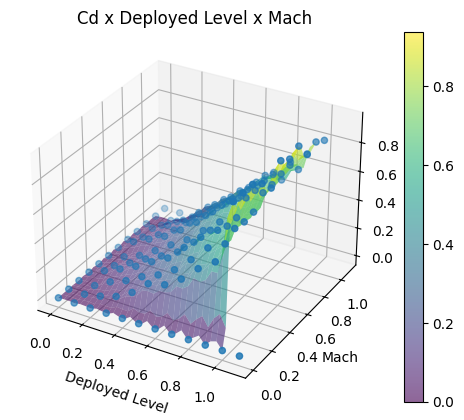

In [7]:
air_brakes.all_info()

## Simulating a Flight

To simulate the air brakes succesfully, we must set `time_overshoot` to `False`. This way the simulation will run at the time step defined by our sampling rate. Be aware that this will make the simulation **much** run slower.

Also, we are terminating the simulation at apogee, by setting `terminate_at_apogee` to `True`. This way the simulation will stop when the rocket reaches apogee, and we will save some time.

In [8]:
test_flight = Flight(
    rocket=calisto, environment=env, rail_length=5.2, inclination=85, heading=0, time_overshoot=False, terminate_on_apogee=True
)

## Analyzing the Results

Now we can see some plots from our air brakes:

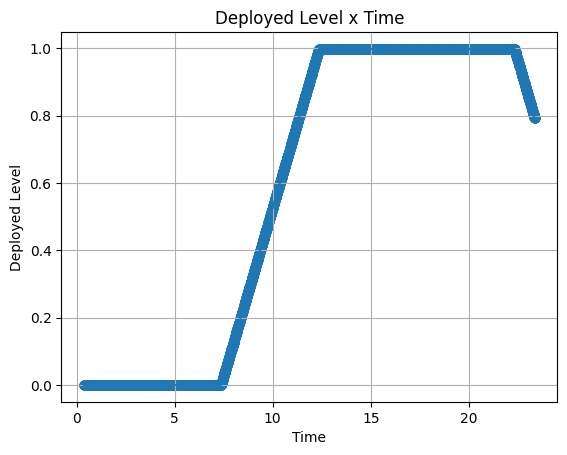

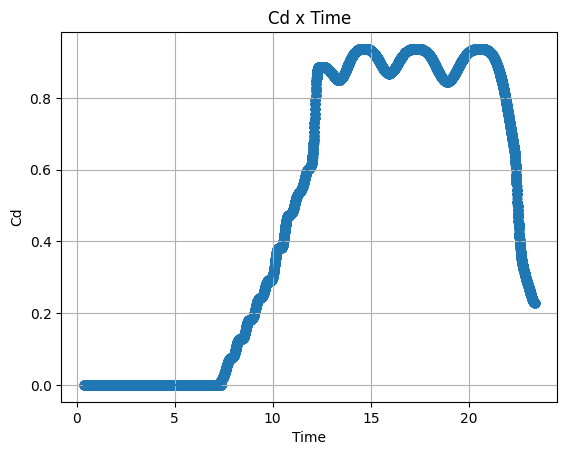

In [9]:
air_brakes.deployed_level_by_time.plot(force_data=True)
air_brakes.cd_by_time.plot(force_data=True)

And of course, the simulation results:

3000.1746810329305


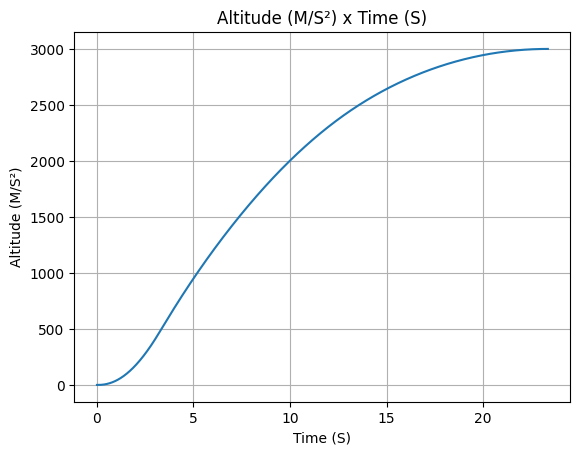

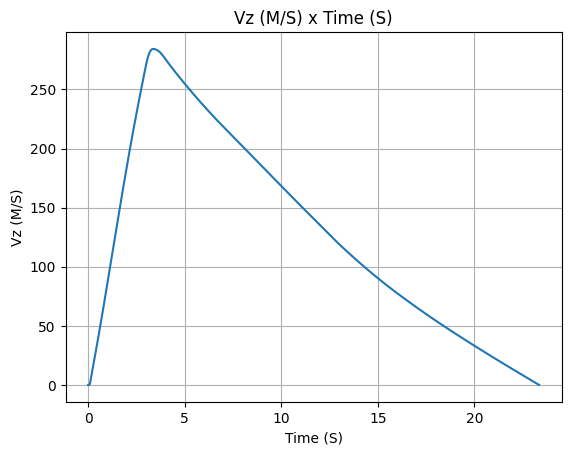

In [10]:
print(test_flight.apogee-env.elevation)
test_flight.altitude()
test_flight.vz()


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1400.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.999 | e1: -0.044 | e2: -0.000 | e3: 0.000
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: 0.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.2  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 0.00°


Rail Departure State

Rail Departure Time: 0.368 s
Rail Departure Velocity: 26.205 m/s
Rail Departure Stability Margin: 2.276 c
Rail Departure Angle of Attack: -0.000°
Rail Departure Thrust-Weight Ratio: 10.152
Rail Departure Reynolds Number: 2.040e+05


Burn out State

Burn out time: 3.900 s
Altitude at burn out: 657.341 m (AGL)
Rocket velocity at burn out: 279.590 m/s
Freestream velocity at burn out: 279.590 m/s
Mach Number at burn out: 0.843
Kinetic energy at burn ou

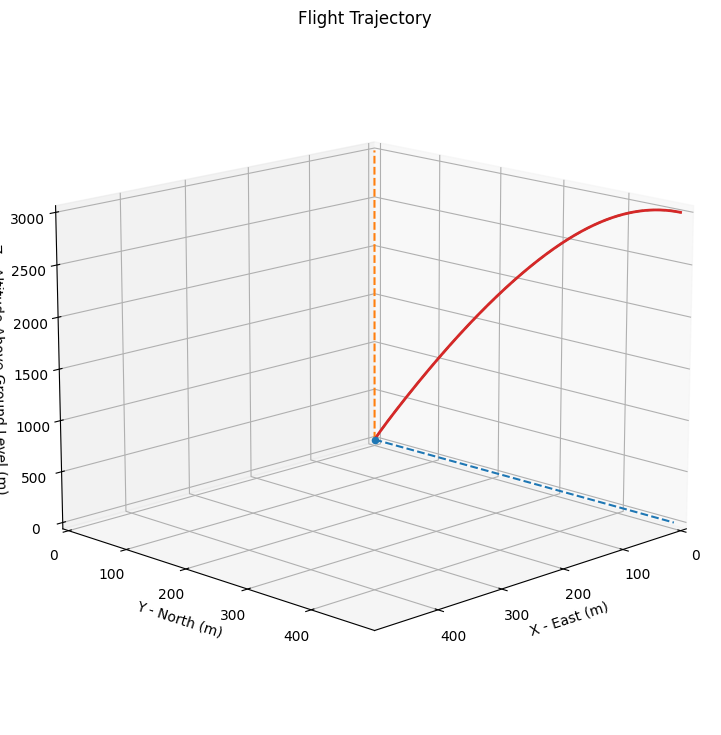



Trajectory Kinematic Plots



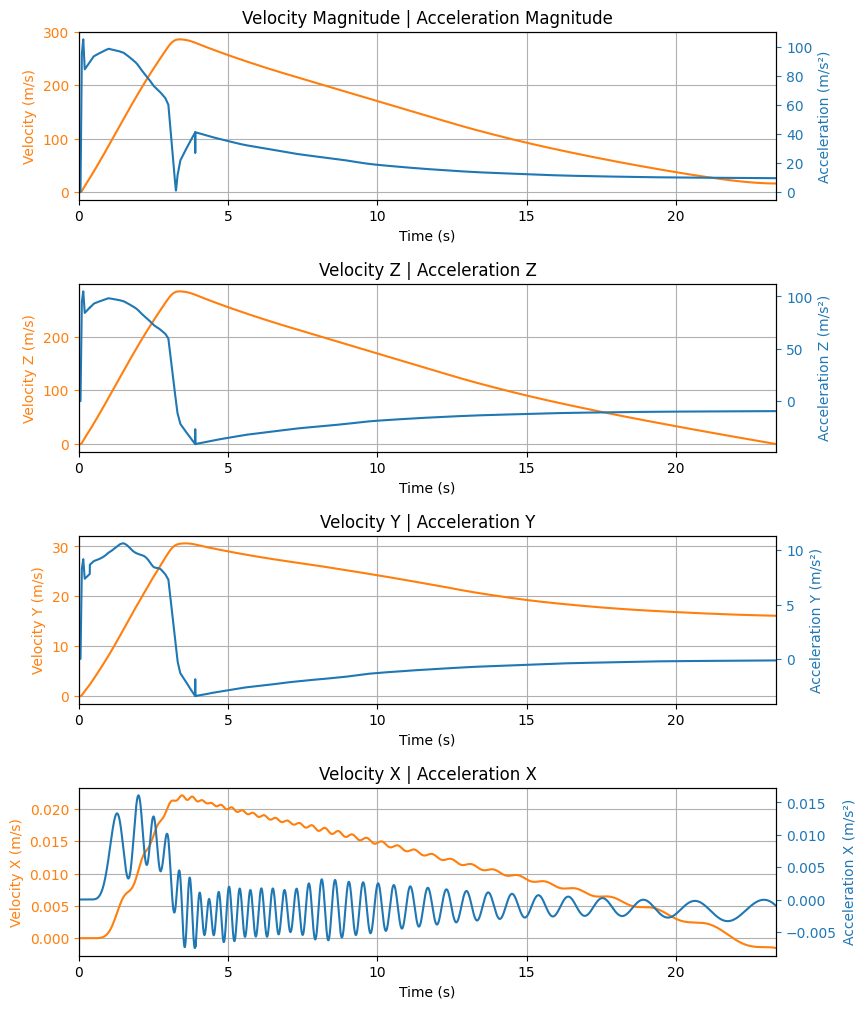



Angular Position Plots



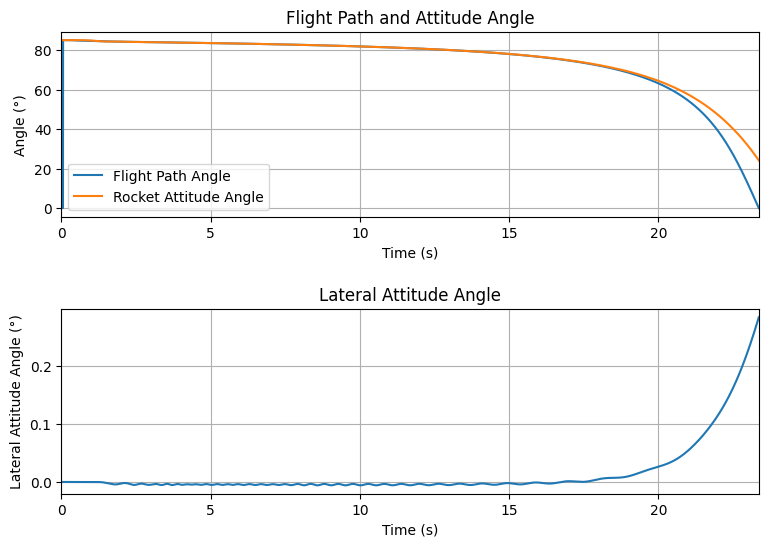



Path, Attitude and Lateral Attitude Angle plots



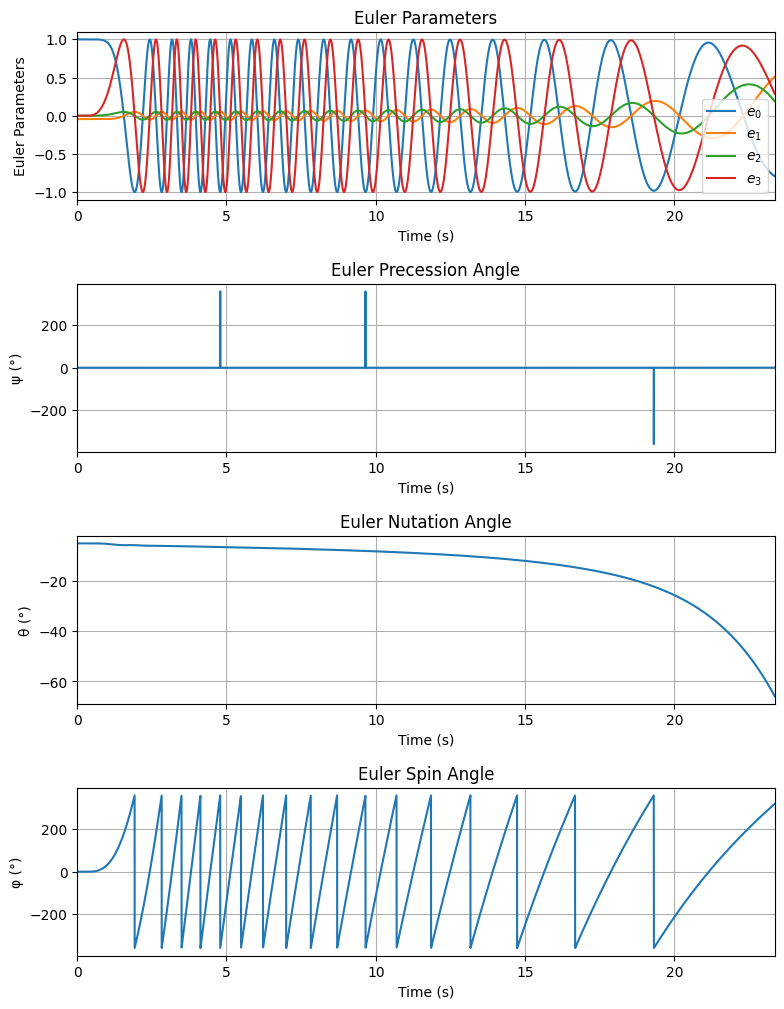



Trajectory Angular Velocity and Acceleration Plots



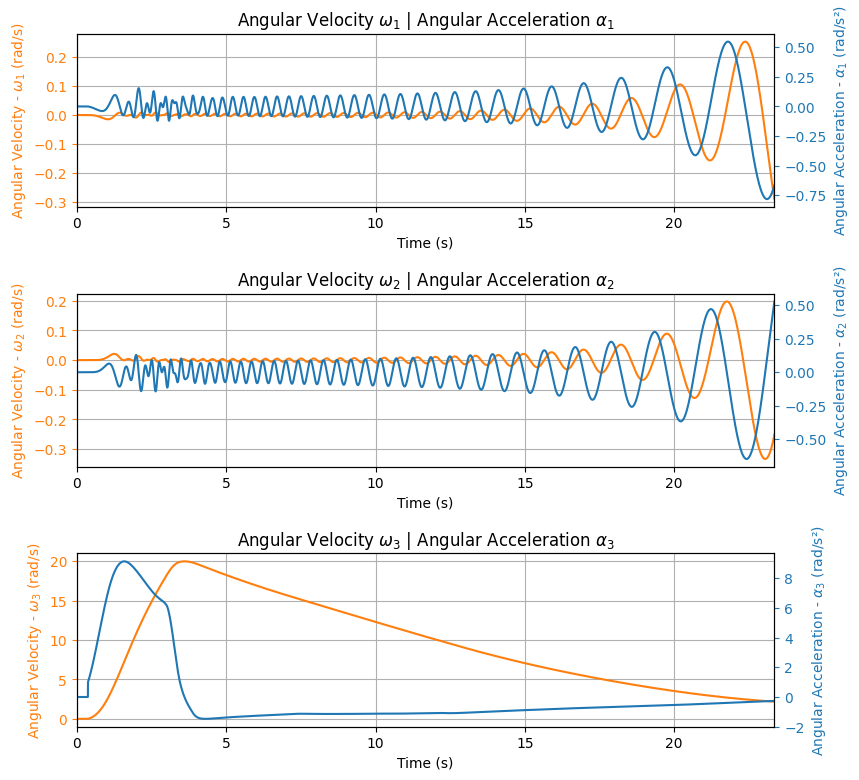



Aerodynamic Forces Plots



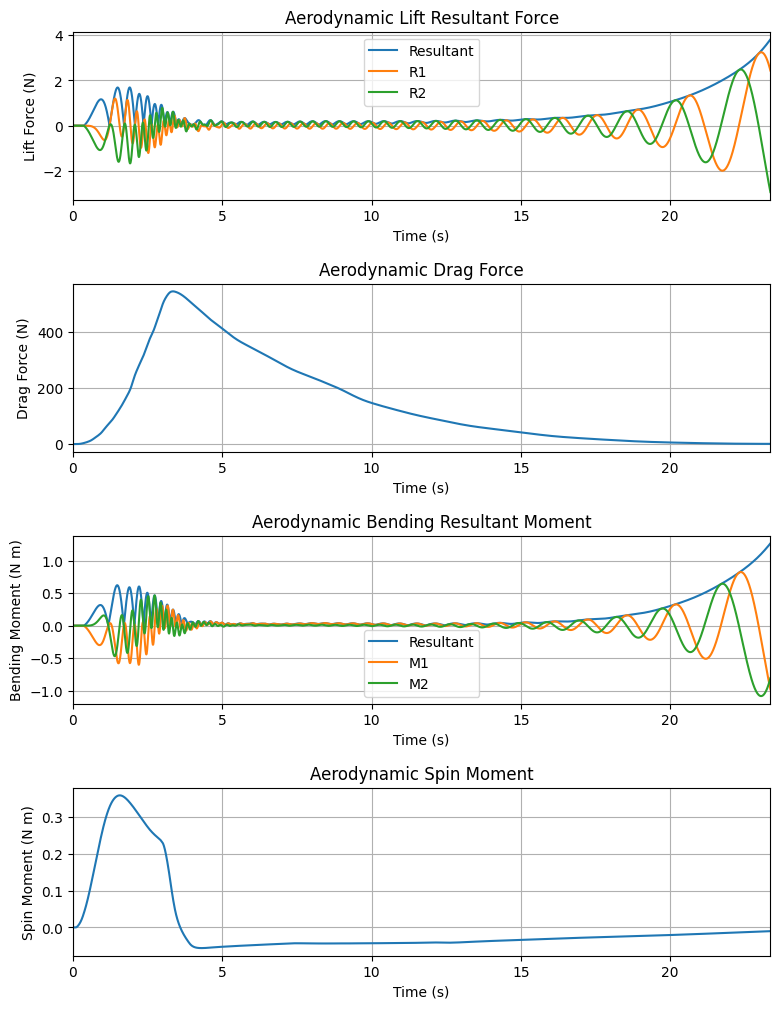



Rail Buttons Forces Plots



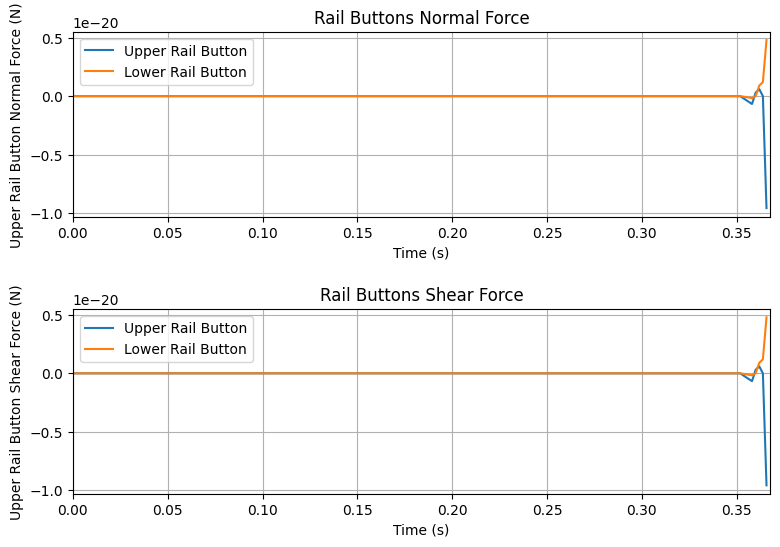



Trajectory Energy Plots



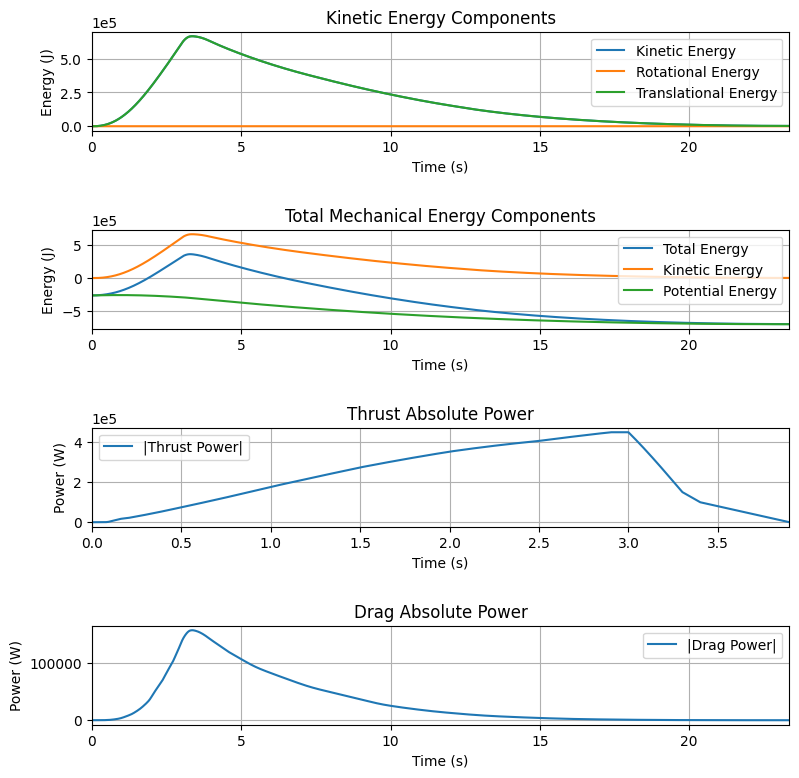



Trajectory Fluid Mechanics Plots



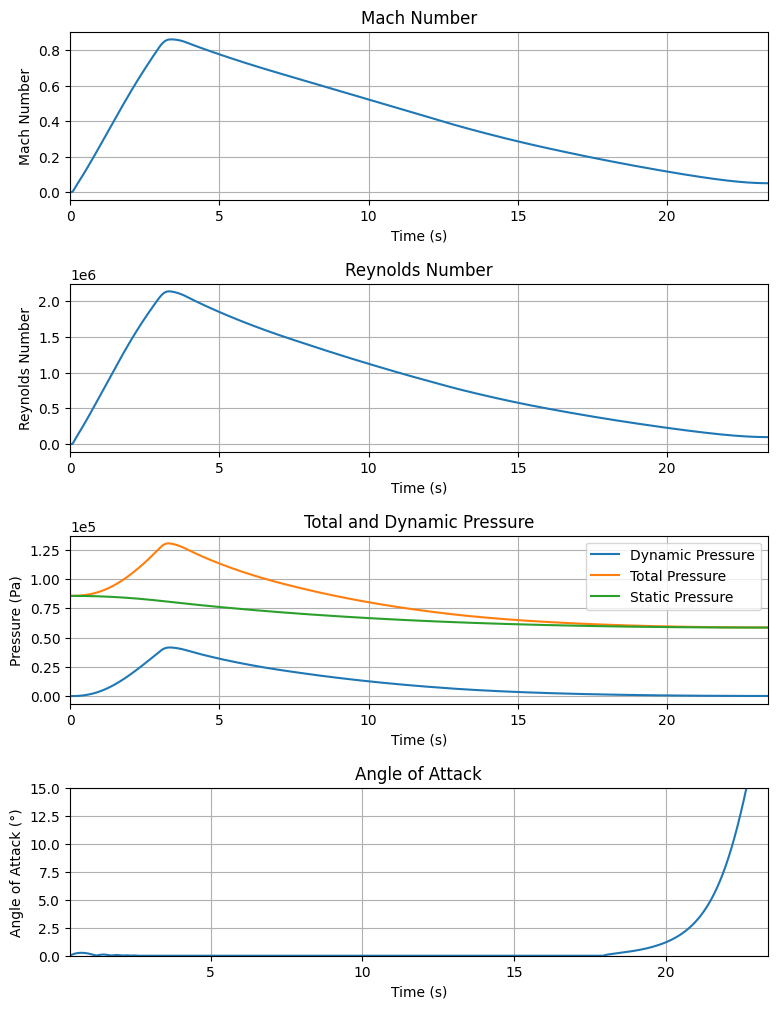



Trajectory Stability and Control Plots



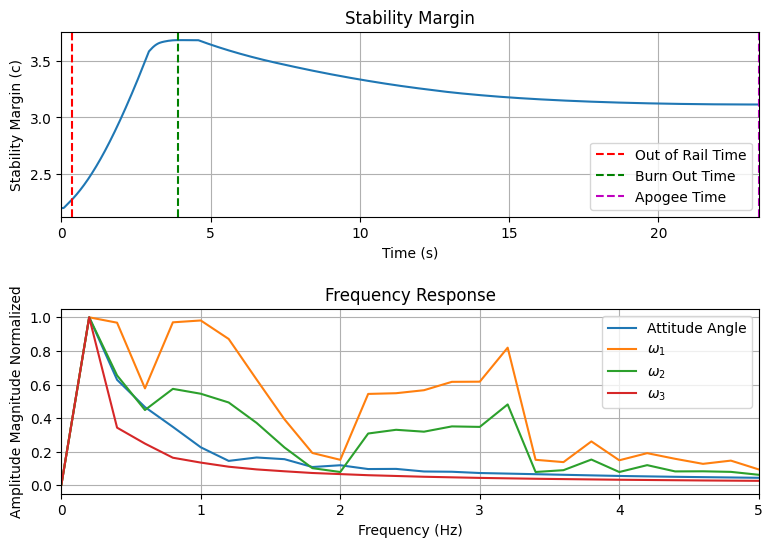



Rocket and Parachute Pressure Plots



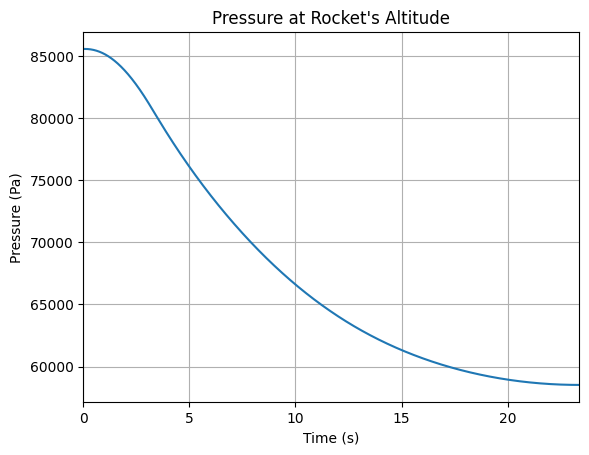


Rocket has no parachutes. No parachute plots available


In [11]:
test_flight.all_info()